#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [2]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [2]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json


In [3]:
wikipedia.set_lang("en")  #We make our research in english

#### definition of the function for the CORPUS SELECTION

In [3]:
def function_to_get_all_the_bloody_titles(key_words : str)-> (list[str],int):
    ''' 
    
    '''
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=5000&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    for interest in soup.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles, nbr_result

In [4]:
def get_section_titles(page : str) -> list[str]:
    '''
    Returns the section titles

    :param page: Title of the page
    :return: The list of section titles
    '''
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [5]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys : str , number_of_results, key_for_section) -> list[str]:
    '''
    Select the corpus if the keywords are in the section or in the title

    :param word_keys : string 
    
    :return: a dictionnary containing the title of all the pages of the corpus
    '''
    corpus = []
    proper_list = []
    left_list = []
    function = function_to_get_all_the_bloody_titles(word_keys)
    nbr_result = function[1]
    search_list = function[0] #Select and put in a list number_of_results wikipedia articles related to word_keys
    
    for article in tqdm(search_list):
        try:
            wikipedia.summary(article, auto_suggest = False)
            proper_list.append(article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(article, auto_suggest = False)
                proper_list.append(article)
            except wikipedia.exceptions.PageError as e:
                pass
    
    for proper_article in tqdm(proper_list):
        if key_for_section in proper_article.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(proper_article)
        else:
            left_list.append(proper_article) #Put the rest of the articles in a list
            
    for left_article in tqdm(left_list):
        sec_tit = []
        try :
            sec_tit = get_section_titles(left_article)
            for section in sec_tit:
                if key_for_section.lower() in section.lower() and left_article not in corpus:
                    corpus.append(left_article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(left_article)
                for section in sec_tit:
                    if key_for_section.lower() in section.lower() and left_article not in corpus:
                        corpus.append(left_article)
            except wikipedia.exceptions.PageError as e:
                pass

    return corpus[:number_of_results]

## TO LAUNCH THE CORPUS SELECTION

In [7]:
%%time
search_list = corpus_selection("Effects of climate change", 5000, 'climate change')


  1%|▉                                                                               | 57/5000 [00:30<42:35,  1.93it/s]C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
100%|██████████████████████████████████████████████████████████████████████████████| 4776/4776 [46:31<00:00,  1.71it/s]

Wall time: 1h 31min 5s


In [8]:
len(search_list)

921

In [40]:
search_list=["Effects of climate change"]

### Get the information on the protected articles of the corpus

In [41]:
def protection_status(data):
    
    years_off = []
    for i in range(22):
        years_off.append(2001+i)
    
    wrong_ones = []
    dot = pd.DataFrame(years_off)
    
    for article in data:
        
        html_text = requests.get(('https://en.wikipedia.org/wiki/Special:Log?type=protect&user=&page={}&wpdate=&tagfilter=&subtype=').format(article)).text
        soup = BeautifulSoup(html_text, 'lxml')
        dic = {}
        results = soup.find_all('li', {'class' : 'mw-logline-protect'})
        
        for i in results:
            z = i.find('a')
            protection = i.get('data-mw-logaction')
            date = str(z)[str(z).find('Log">') + 5:str(z).find('</a>')]
            dic[pd.to_datetime(date, format = '%H:%M, %d %B %Y')] = protection
        
        if 'expires' in str(results):
            res = str(results).split('span')
            for string in res:
                if '] (expires' in string:
                    date_get = string[string.find('] (expires ') + 11:string.find(' (UTC))')]
                    if ') [' in date_get:
                        date_get = date_get[:date_get.find(') [')]
                    if '] (' in date_get:
                        date_get = date_get[date_get.find(', '):]
                    if ')' in date_get:
                        date_get = date_get.replace(')', '')
                    if date_get[:2] == ', ':
                        date_get = date_get[2:]
                    if date_get[-1] == ' ':
                        date_get = date_get[:-1]
                    if ',' in date_get:
                        date_get = date_get.replace(',', '')
                    try:
                        dic[pd.to_datetime(date_get, format = '%H:%M %d %B %Y')] = 'protect/unprotect'
                    except:
                        try:
                            dic[pd.to_datetime(date_get, format = '%H:%M %B %d %Y')] = 'protect/unprotect'
                        except:
                            wrong_ones.append(article)

        if len(dic) != 0:
            dic = dict(sorted(dic.items()))
            new_dic = {}
            s = set()
            list_date = list(dic.keys())[::-1]
            for date in list_date:
                s.add(date.year)
            for j in sorted(s):
                deadline = pd.to_datetime('30 June {} 00:00:00'.format(j))
                same_year = []
                for date in list_date:
                    if date.year == deadline.year and date <= deadline:
                        same_year.append(date)
                        if len(same_year) != 0:
                            new_dic[deadline.year] = dic[max(same_year)]
                    else :
                        if date.year == deadline.year and date > pd.to_datetime('30 June {}'.format(max(s))):
                            new_dic[max(s) + 1] = dic[max(list_date)]

            keys = list(new_dic.keys())
            for year in years_off:
                if year < min(keys):
                    new_dic[year] = 'protect/unprotect'
                elif year > max(keys):
                    new_dic[year] = new_dic[max(keys)]
                else:
                    for low in keys:
                        for high in keys:
                            if year > low and year < high and len(keys[keys.index(low):keys.index(high)]) == 1:
                                new_dic[year] = new_dic[low]
                                
            d = dict(sorted(new_dic.items()))
            
            if len(d) == 22:
                dot[article] = d.values()
            else:
                dot[article] = list(d.values())[:22]
        
    return dot

In [ ]:
protection_status_evolution = protection_status(search_list)

#### creation of the dataframe

In [42]:
%%time
def crea_dataframe(search_list : list,keyword : str)-> pd.DataFrame:
    '''
    param search_list: liste containing the name of all the articles
    param keyword: string containing the keyword that we want to scrap
    
    
    return: data frame containg the name, the url and the wikicode of the entire page if the keyword is in the title.
    If it's not it returns the wiki code of the section containing the keyword only. Or return the wikicode for each entire page if the line with recode are commented
    '''
    tableau =[] #creation of a list that will contain a dictionnary for each page with the information
    
   
    
    #browse all the titles  of the search list
    for i in tqdm(range(len(search_list))):
             
        #find the wikipedia page
        page =wikipedia.page(search_list[i], auto_suggest = False)
        page_title =page.title #give the clean name of the page
        page_url=page.url #give the url of the page
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, page_title)
        
        page_text=page.text            
        infopage ={'Name only' : page_title, 'page url' :page_url,'text':page_text}
        tableau.append(infopage)
    
    return tableau


tableau=crea_dataframe(search_list,"climate change")
#df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

Wall time: 956 ms


In [43]:
# %load '2008.txt'
def text_import(year):
    filename =str(year) +".txt"
    dataframe_name = pd.read_csv(filename, sep = '\t')
    return str(dataframe_name)

In [44]:
 #creation of a list that will contain a dictionnary for each page with the information
for i in range(2006,2022):
    page =wikipedia.page(search_list[0], auto_suggest = False)
    page_title =i #give the clean name of the page
    page_url= "https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change&oldid=298597212" #give the url of the page
    text=text_import(str(i))
    infopage ={'Name only' : page_title, 'page url' :page_url,'text':text}
    tableau.append(infopage)
df=pd.DataFrame.from_dict(tableau)

#### definition of the function for the extraction of citation

In [63]:
# Some additional functions
def get_ids_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a doi or a pmid or a pmc and if it's the case the return it 
    Also returns the name of the journal in which the article has been published
    
    param ref : the string of a reference
    
    return ids:  a dictionnary containing the doi or pmid or pmc and the journal of the reference if it's a scientific reference
    '''
    print("beg ref", ref,"end")
    d = dict(re.findall(r'(doi|pmc|pmid)(?:(?:\s?[=\|]\s?)|(?:\.)|(?:(?:])*?:)|(?:\s|\/)|(?: *=))([^|\s}]*)', ref))
    if d!={}:
        recode=re.findall(r'(?:journal|publisher) *?=((?:\w| |\[|-|\.)*)',ref) +re.findall(r',?(?P<journal>(\s(\w+))+), (V|v)ol',ref) 
        if recode!= []:
            d["journal"]= recode
    
    ids = {k: v for k, v in d.items() if v}    
    return ids

        
def get_citations(wikicode : str)-> dict:
    '''
    param  wikicode: a string containing the wikicode of the page or section of which we want to extract the code
    
    return a dictionnary containing all the information about the citation we want to extract
    '''
    #detection of the citations in the wikicode
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>((?:.|\n)*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations:
        i+=1
        s.update(c.split('<br/>'))
        
    #Creation of a dataframe containing the citation    
    ds = pd.DataFrame(s, columns=['ref'])
    
   
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    ds["journal"]=ds['ids'].apply(lambda x: x.get('journal', None))
    ds["available"]=ds["ids"]== {}
    
    
    dsbis= ds[(~ds['pmid'].isnull())|~(ds['doi'].isnull())|~(ds['pmc'].isnull())]
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]


    dg=ds.loc[ds["available"]==True,["ref"]]
    dg['ids']=dg['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    dg['IPCC'] = dg['ids'].apply(lambda x: x.get('IPCC', None))
    dg['ipbes'] = dg['ids'].apply(lambda x: x.get('ipbes', None))
    dg['guard'] = dg['ids'].apply(lambda x: x.get('guardian', None))
    dg["available"]= dg["ids"]=={}
    
    
    dcit=dg.loc[dg["available"]==True,["ref"]]
    dcit['ids'] = dcit['ref'].apply(get_cit_from_ref)
    dcit['org'] = dcit['ids'].apply(lambda x: x.get('org', None))
    dcit['gov'] = dcit['ids'].apply(lambda x: x.get('gov', None))
    dcit['com'] = dcit['ids'].apply(lambda x: x.get('com', None))
    dcit['ncbi'] = dcit['ids'].apply(lambda x: x.get('ncbi.nlm.nih.gov', None))
    dcit["available"]= dcit["ids"]=={}
    
    #creation of a data frame with all the other type of citation that weren't extracted
    drest = dcit.loc[dcit["available"]==True,["ref"]]
    
    dsbis=ds[(~ds['journal'].isnull())]
    dgbisgov=dcit[(~dcit['gov'].isnull())]    
    dgbisorg=dcit[(~dcit['org'].isnull())]
    dgbisIPCC=dg[(~dg['IPCC'].isnull())]    
    dgbiscom=dcit[(~dcit['com'].isnull())]
    dgbisncbi=dcit[(~dcit['ncbi'].isnull())]
    
    dic = {'Ref count': ds.shape[0],
           'journal_count': dsbis.shape[0]+ dcit[(~dcit['ncbi'].isnull())].shape[0],
           'nb_journal_citations': (dcit[(~dcit['ncbi'].isnull())]).shape[0]+ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],
           "citationjournal":list(list(dsbis["doi"])+list(dsbis["pmid"])+list(dsbis["pmc"])+list(dgbisncbi["ncbi"])),
           "citations.org": dcit[(~dcit['org'].isnull())].shape[0],
           "citations.gov": dcit[(~dcit['gov'].isnull())].shape[0],
           "citationgovtext":list(dgbisgov['gov']),
           "citationorgtext":list(dgbisorg['org']),
           "citationsIPCC.ch": dg[(~dg['IPCC'].isnull())].shape[0],
           "citationautre":drest["ref"].shape[0],
           "citationcomtext":list(dgbiscom['com']),
           "journal":list(dsbis['journal'])+list(dgbisncbi["ncbi"]),
           "citations.com": dcit[(~dcit['com'].isnull())].shape[0],
           "citationsipbes": dg[(~dg['ipbes'].isnull())].shape[0],
           "citationguardian": dg[(~dg['guard'].isnull())].shape[0]}
    
    return dic

In [64]:


def get_cit_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a.org, .gov or .com citation except if it's a guardian citation
    
    param ref : the string of a citation
    
    return ids:  a dictionnary containing as keys org, gov and com and in values the name of the site of the citation
    '''
    d = dict(re.findall(r"((?:[(?:\.)(?:\-)\w]*)\.(org|com|gov))", ref, flags=re.IGNORECASE))
    
    #remove the archive because we don't want to count them in the number of .org citation
    if 'archive.org' in d :
        d.pop('archive.org', None)
    if "web.archive.org" in d:
        d.pop('web.archive.org', None)
    if "www.webcitation.org" in d:
        d.pop('www.webcitation.org', None)
    if "ghostarchive.org" in d:
        d.pop("ghostarchive.org", None)
    if "www.ncbi.nlm.nih.gov" in d or "ncbi.nlm.nih.gov" in d:
        d.pop("www.ncbi.nlm.nih.gov", None)
        d.pop("ncbi.nlm.nih.gov",None)
        d["ncbi"]="ncbi.nlm.nih.gov"
        
        
    ids = {v: k for k, v in d.items() if v}
    
    return ids


In [65]:
def get_IPCC_guardian_ipbes_from_ref(ref: str) -> dict:
    '''
    detects if the reference entering this program is an IPCC, ipbes or guardian citation
    
    param ref : the string of a citation
    
    return :  a dictionnary containing as keys guardian, ipbes and IPCC and in values the name of the citation extracted
    '''
    g={}
    citation=list(set(re.findall(r"(ipcc|ipbes|guardian)", ref, flags=re.IGNORECASE)))
    if citation !=None and citation !=[]:
        if "ipcc" in citation:
            g["IPCC"]=citation
        if "ipbes" in citation:
            g["ipbes"]=citation
        if "guardian" in citation:
            g["guardian"]=citation
        return g
    else:
        return{}

## Get the citations

In [66]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))

print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])

print("getting the number of scientific citations")
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])
df["journal"] = df['citations'].progress_apply(lambda x: x['journal'])

print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])

print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

print("getting the other citation")
df["citationautre"]=df['citations'].progress_apply(lambda x: x["citationautre"])

df["org score"]=df["citation org"]/df["Ref count"]
df["gov score"]=df["citation gov"]/df["Ref count"]
df["com score"]=df["citation com"]/df["Ref count"]
df["Sci score"]=df['nb_journal_citations']/df['Ref count']
df['IPCC score']=(df['citation IPCC']+df['citationipbes'])/df['Ref count']
#df['percentage of official sources']=(df['nb_journal_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

Getting citations


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

beg ref {{cite book|last1=jansen|first1=e.|title=in {{harvnb|ipcc ar4 wg1|2007}}|last2=overpeck|first2=j.|last3=briffa|first3=k. r.|last4=duplessy|first4=j.-c.|last5=joos|first5=f.|last6=masson-delmotte|first6=v.|last7=olago|first7=d.|last8=otto-bliesner|first8=b.|last9=peltier|first9=w. r.|at=[http://archive.ipcc.ch/publications_and_data/ar4/wg1/en/ch6s6-3-2.html sec. 6.3.2 what does the record of the mid-pliocene show?]|chapter=chapter 6: palaeoclimate|display-authors=4|access-date=28 december 2018|chapter-url=http://archive.ipcc.ch/publications_and_data/ar4/wg1/en/ch6.html|archive-url=https://web.archive.org/web/20181223122502/https://archive.ipcc.ch/publications_and_data/ar4/wg1/en/ch6.html|archive-date=23 december 2018|url-status=live|first14=o.|last14=solomina|first15=r.|last15=villalba|first16=d.|last16=zhang|last13=rind|first13=d.|last12=raynaud|first12=d.|last11=ramesh|first11=r.|first10=s.|last10=rahmstorf}} end
beg ref {{cite web|archive-url=https://web.archive.org/web/20220

 12%|█████████▊                                                                         | 2/17 [00:00<00:02,  7.33it/s]

{{cite book |last1=jiménez cisneros |first1=b. e. |title={{harvnb|ipcc ar5 wg2 a|2014}} end
beg ref {{cite journal |last=sabūnas |first=audrius |last2=miyashita |first2=takuya |last3=fukui |first3=nobuki |last4=shimura |first4=tomoya |last5=mori |first5=nobuhito |title=impact assessment of storm surge and climate change-enhanced sea level rise on atoll nations: a case study of the tarawa atoll, kiribati |url=https://www.frontiersin.org/articles/10.3389/fbuil.2021.752599/full |journal=frontiers in built environment |access-date=24 april 2022 |doi=10.3389/fbuil.2021.752599|date=10 november 2021}} end
beg ref {{cite book |last1=begum |first1=rawshan ara |title=climate change 2022: impacts, adaptation and vulnerability |last2=lempert |first2=robert  |publisher=[[intergovernmental panel on climate change]] |series=contribution of working group ii to the [[ipcc sixth assessment report|sixth assessment report]] of the intergovernmental panel on climate change  |chapter=chapter 1: point of dep

 24%|███████████████████▌                                                               | 4/17 [00:00<00:01, 10.76it/s]

 end
beg ref unep (2002) [http://www.unepfi.org/fileadmin/documents/ceo_briefing_climate_change_2002_en.pdf "key findings of unep’s finance initiatives study"] ''ceobriefing'' end
beg ref http://news.independent.co.uk/environment/article2099971.ece end
beg ref http://www.nature.com/nature/journal/v438/n7066/full/nature04141.html end
beg ref http://www.agu.org/meetings/fm05/fm05-sessions/fm05_c41a.html end
beg ref http://www.sciencemag.org/cgi/content/full/295/5558/1275?ijkey=nfvdolnylmnzu&keytype=ref&siteid=sci end
beg ref http://www.guardian.co.uk/climatechange/story/0,12374,1063181,00.html end
beg ref http://www.guardian.co.uk/climatechange/story/0,12374,1517940,00.html end
beg ref http://www.nichols.edu/departments/glacier/ end
beg ref http://www.guardian.co.uk/climatechange/story/0,12374,1517935,00.html end
beg ref http://www.risingtide.nl/greenpepper/envracism/refugees.html end
beg ref [http://news.bbc.co.uk/1/hi/world/south_asia/3102948.stm bbc - fears rise for sinking sundarbans

 35%|█████████████████████████████▎                                                     | 6/17 [00:00<00:01,  8.40it/s]

 end
beg ref {{cite journal |last=freeman |first=chris |authorlink= |coauthors=ostle, nick; kang, hojeong |year=2001 |month= |title=an enzymic 'latch' on a global carbon store |journal=nature |volume=409 |issue=6817 |pages=149 |doi=10.1038/35051650 |url= |accessdate= |quote= }} end
beg ref {{cite journal | last = root | first = terry l. | coauthors = jeff t. price, kimberly r. hall, stephen h. schneider, cynthia rosenzweig & alan pounds | title = fingerprints of global warming on animals and plants | journal = [[nature (journal)|nature]] | volume = 421 | issue = 6918 | pages = 57–59 | date = [[2003-01-02]] | url = http://cesp.stanford.edu/publications/fingerprints_of_global_warming_on_animals_and_plants/index.html | accessdate = 2008-02-13 | doi = 10.1038/nature01333 | format = {{dead link|date=may 2009}}}} end
beg ref {{cite journal | author = schär, c. | coauthors = jendritzky, g. | year = 2004 | title = hot news from summer 2003 | journal = nature | volume = 432 | issue = 7017 | pag

 47%|███████████████████████████████████████                                            | 8/17 [00:00<00:00,  9.15it/s]

beg ref {{cite book |author=wilbanks, tj ''et al'' |chapter=industry, settlement and society |chapterurl=http://www.ipcc.ch/publications_and_data/ar4/wg2/en/ch7.html | publisher = ipcc | location = ch |editor={{harvnb|parry|2007|pp=357–90}} }} end
beg ref  {{cite book | author=easterling, we, ''et al'' | contribution=5.6.5 food security and vulnerability | series=chapter 5: food, fibre, and forest products | url=http://www.ipcc.ch/publications_and_data/ar4/wg2/en/ch5s5-6-5.html | editor={{harvnb|parry|2007}} | accessdate=2011-06-25}}  end
beg ref {{cite book |year=2007 |contribution=3.1 emissions scenarios |title= issues related to mitigation in the long term context |series=climate change 2007: mitigation. contribution of working group iii to the fourth assessment report of the intergovernmental panel on climate change |editor=b metz, ''et al'' |publisher= cambridge university press; ipcc | location = cambrige, uk & new york, ny, usa; ch |author=fisher, bs, ''et al'' |url=http://www.i

beg ref  {{cite book |year= 2009 |author= granger morgan, m. (lead author), h. dowlatabadi, m. henrion, d. keith, r. lempert, s. mcbride, m. small and t. wilbanks (contributing authors) |title= synthesis and assessment product 5.2: best practice approaches for characterizing, communicating, and incorporating scientific uncertainty in decisionmaking. a report by the u.s. [[climate change science program]] and the subcommittee on global change research |publisher= national oceanic and atmospheric administration |location= washington d.c., usa. |pages= 19–20; 27–28 |url= http://www.globalchange.gov/publications/reports/scientific-assessments/saps/311 }} tables 2.1 and 2.2 on pages 27-28 show two quantitative scales of uncertainty which are used in the tar and ar4. end
beg ref  {{citation |author= ipcc |chapter= synthesis report |chapter-url= http://www.grida.no/climate/ipcc_tar/vol4/english/016.htm |at= [http://www.grida.no/climate/ipcc_tar/vol4/english/025.htm question 2, sections 2.25 a

 59%|████████████████████████████████████████████████▏                                 | 10/17 [00:01<00:00,  7.72it/s]

beg ref  {{citation | author=barnett, t.p., ''et al.'' | date=17 november 2005 | title=potential impacts of a warming climate on water availability in snow-dominated regions: abstract | work=nature | volume=438 | page=303 | url=http://meteora.ucsd.edu/cap/pdffiles/barnett_warmsnow.pdf | doi=10.1038/nature04141 |bibcode = 2005natur.438..303b | pmid=16292301}}  end
beg ref {{cite doi |10.1038/ngeo420}} end
beg ref  {{citation |author= meehl ''et al.'' |chapter= chapter 10: global climate projections |chapter-url= http://www.ipcc.ch/publications_and_data/ar4/wg1/en/ch10.html |at= [http://www.ipcc.ch/publications_and_data/ar4/wg1/en/ch10s10-es-8-sea-level.html executive summary] }}, in {{harvnb|ipcc ar4 wg1|2007}}.  end
beg ref  {{citation | title=2011 arctic sea ice minimum | url=http://www.climatewatch.noaa.gov/article/2012/state-of-the-climate-2011-arctic-sea-ice-extent }}, in {{harvnb|kennedy|2012}}  end
beg ref  {{citation |author= hegerl ''et al'' |chapter= chapter 9: understanding a

 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [00:01<00:00,  6.50it/s]

beg ref  {{citation | author=barnett, t.p., ''et al.'' | date=17 november 2005 | title=potential impacts of a warming climate on water availability in snow-dominated regions: abstract | work=nature | volume=438 | page=303 | url=http://meteora.ucsd.edu/cap/pdffiles/barnett_warmsnow.pdf | doi=10.1038/nature04141 |bibcode = 2005natur.438..303b | pmid=16292301}}  end
beg ref oppenheimer, m., ''et al.'', ''section 19.6.2.2. the role of adaptation and alternative development pathways,'' in: [http://ipcc-wg2.gov/ar5/images/uploads/wgiiar5-chap19_final.pdf chapter 19: emergent risks and key vulnerabilities] (archived [https://web.archive.org/web/20141020014746/http://ipcc-wg2.gov/ar5/images/uploads/wgiiar5-chap19_final.pdf 20 october 2014]), pp.1072-1073, in {{harvnb|ipcc ar5 wg2 a|2014}}  end
beg ref {{cite doi |10.1038/ngeo420}} end
beg ref {{cite book | ref=citerefus nrc2010 | isbn = 0-309-14588-0 | title =advancing the science of climate change. a report by the us national research council

 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [00:01<00:00,  6.60it/s]

end
beg ref  {{citation | author= schneider | chapter= chapter 19: assessing key vulnerabilities and the risk from climate change | chapter-url= http://www.ipcc.ch/publications_and_data/ar4/wg2/en/ch19.html | at= [http://www.ipcc.ch/publications_and_data/ar4/wg2/en/ch19s19-3-7.html sec. 19.3.7 update on ‘reasons for concern’] |display-authors=etal}}, p. 796, in {{harvnb|ipcc ar4 wg2|2007}}.  end
beg ref  {{citation |author= smith |chapter= chapter 19: vulnerability to climate change and reasons for concern: a synthesis |chapter-url= http://www.grida.no/climate/ipcc_tar/wg2/657.htm |at= [http://www.grida.no/climate/ipcc_tar/wg2/686.htm#19825 sec. 19.8.2.5. large-scale singularities] |display-authors=etal}}, in {{harvnb|ipcc tar wg2|2001}}.  end
beg ref  {{harvnb|molina|others|n.d.|p=3}}  end
beg ref  {{citation | author=solomon, s. | chapter=technical summary | chapter-url=http://www.ipcc.ch/publications_and_data/ar4/wg1/en/ts.html | at=[http://www.ipcc.ch/publications_and_data/ar4/wg1/

 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [00:01<00:00,  6.60it/s]

 {{citation | author=solomon, s. | chapter=technical summary | chapter-url=http://www.ipcc.ch/publications_and_data/ar4/wg1/en/ts.html | at=[http://www.ipcc.ch/publications_and_data/ar4/wg1/en/tssts-5-2.html ts.5.2 large-scale projections for the 21st century] |display-authors=etal}}, in {{harvnb|ipcc ar4 wg1|2007}}  end
beg ref  {{harvnb|allison|others|2009}}  end
beg ref  some of these impacts are included in table spm.2: {{citation | at=[http://www.ipcc.ch/publications_and_data/ar4/syr/en/spms3.html#spm2 3 projected climate change and its impacts: table spm.2] | chapter=summary for policymakers | chapter-url=http://www.ipcc.ch/publications_and_data/ar4/syr/en/spm.html }}, in {{harvnb|ipcc ar4 syr|2007|pp=11–12}}  end
beg ref  {{citation | author=field, c.b. | chapter=ch 14: north america | chapter-url=http://www.ipcc.ch/publications_and_data/ar4/wg2/en/ch14.html | at=[http://www.ipcc.ch/publications_and_data/ar4/wg2/en/ch14s14-4.html#14-4-1 sec 14.4.1 freshwater resources: surface w

 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [00:02<00:00,  5.62it/s]

  {{cite web | author=us environmental protection agency | url=http://www.epa.gov/climatechange/science/overview.html | title=science: climate change: us epa (climate change science overview) | publisher=us epa | date=14 june 2012 }}  end
beg ref  {{citation |author= smith |chapter= chapter 19: vulnerability to climate change and reasons for concern: a synthesis |chapter-url= http://www.grida.no/climate/ipcc_tar/wg2/657.htm |at= [http://www.grida.no/climate/ipcc_tar/wg2/686.htm#19823 sec. 19.8.2.3. aggregate impacts] |display-authors=etal}}, in {{harvnb|ipcc tar wg2|2001}}.  end
beg ref spm.3 trends in stocks and flows of greenhouse gases and their drivers, in: [http://report.mitigation2014.org/spm/ipcc_wg3_ar5_summary-for-policymakers_approved.pdf summary for policymakers], p.8 (archived [https://web.archive.org/web/20140702014732/http://report.mitigation2014.org/spm/ipcc_wg3_ar5_summary-for-policymakers_approved.pdf 2 july 2014)], in {{harvnb|ipcc ar5 wg3|2014}}. the range given by t

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:02<00:00,  5.92it/s]

end
beg ref {{cite journal |doi=10.1073/pnas.1205276109 |pmid=22869707 |pmc=3443154 |title=perception of climate change |journal=proceedings of the national academy of sciences |volume=109 |issue=37 |pages=e2415–23 |year=2012 |last1=hansen |first1=j |last2=sato |first2=m |last3=ruedy |first3=r }} end
beg ref {{citation |author= ipcc |chapter= summary for policymakers |chapter-url= http://archive.ipcc.ch/publications_and_data/ar4/wg1/en/spm.html |at= [http://archive.ipcc.ch/publications_and_data/ar4/wg1/en/spmsspm-projections-of.html projections of future changes in climate] }}, in {{harvnb|ipcc ar4 wg1|2007}}.  end
beg ref {{cite journal | last1 = ding | first1 = y. | last2 = hayes | first2 = m. j. | last3 = widhalm | first3 = m. | doi = 10.1108/09653561111161752 | title = measuring economic impacts of drought: a review and discussion | journal = disaster prevention and management | volume = 20 | issue = 4 | pages = 434–446 | year = 2011 | pmid = | pmc = }} end
beg ref  {{citation |aut

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.33it/s]


beg ref [https://climateactiontracker.org/global/temperatures/ temperatures], climate action tracker end
beg ref field, c.b., ''et al.'', box ts.8: adaptation limits and transformation, in: [https://ipcc-wg2.gov/ar5/images/uploads/wgiiar5-ts_final.pdf technical summary] (archived [https://web.archive.org/web/20141018073024/https://ipcc-wg2.gov/ar5/images/uploads/wgiiar5-ts_final.pdf 18 october 2014]), p.89, in {{harvnb|ipcc ar5 wg2 a|2014}}  end
beg ref  {{citation |author= solomon |chapter= technical summary |chapter-url= http://archive.ipcc.ch/publications_and_data/ar4/wg1/en/ts.html |title= consistency among observations |at= [http://archive.ipcc.ch/publications_and_data/ar4/wg1/en/tssts-3-4.html ts.3.4 consistency among observations] |display-authors=etal}}, in {{harvnb|ipcc ar4 wg1|2007}}.  end
beg ref  [https://www.ucsusa.org/resources/global-warming-fueling-increased-wildfire-risks is global warming fueling increased wildfire risks?] union of concerned scientists, 24 july 2018 

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.19it/s]


beg ref * {{cite book|author=ipcc|title={{harvnb|ipcc ar5 wg2 a|2014}}|year=2014|page=12|chapter=summary for policymakers|ref={{harvid|ipcc ar5 wg2 summary for policymakers|2014}}|author-link=ipcc|chapter-url=https://archive.ipcc.ch/pdf/assessment-report/ar5/wg2/ar5_wgii_spm_en.pdf}} end
beg ref {{cite journal|last1=clark|first1=peter u.|last2=shakun|first2=jeremy d.|last3=marcott|first3=shaun a.|last4=mix|first4=alan c.|last5=eby|first5=michael|last6=kulp|first6=scott|last7=levermann|first7=anders|last8=milne|first8=glenn a.|last9=pfister|first9=patrik l.|last10=santer|first10=benjamin d.|last11=schrag|first11=daniel p.|date=2016-02-08|title=consequences of twenty-first-century policy for multi-millennial climate and sea-level change|url=https://www.nature.com/articles/nclimate2923|journal=nature climate change|volume=6|issue=4|pages=360–369|doi=10.1038/nclimate2923|bibcode=2016natcc...6..360c|issn=1758-6798}} end
beg ref {{cite book|title={{harvnb|ipcc srocc|2019}}|last1=glavovic|fir

100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1544.73it/s]


getting the number of scientific citations


100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17025.59it/s]


getting the number of .org citation


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 8484.43it/s]


getting the number of .gov citation


100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17070.43it/s]


getting the number of IPCC citation


100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 16972.90it/s]


getting the .com citations


100%|██████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<?, ?it/s]


getting the ipbes citation


100%|██████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<?, ?it/s]


getting the guardian citation


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 8497.58it/s]


getting the other citation


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 8500.62it/s]

Done!


page url  \
Name only                                                      
2022       https://en.wikipedia.org/wiki/Effects_of_clima...   
2006       https://en.wikipedia.org/w/index.php?title=Eff...   
2007       https://en.wikipedia.org/w/index.php?title=Eff...   
2008       https://en.wikipedia.org/w/index.php?title=Eff...   
2009       https://en.wikipedia.org/w/index.php?title=Eff...   

                                                        text  \
Name only                                                      
2022       {{short description|Effects created by climate...   
2006         [[Image:Recent Sea Level Rise.png|right|thum...   
2007       Empty DataFrame\nColumns: [{{See|Global warmin...   
2008       Empty DataFrame\nColumns: [{{pp-semi-protected...   
2009       Empty DataFrame\nColumns: [{{Pp-semi-protected...   

                                                   citations  Ref count  \
Name only                                                                 
2022       {'Ref count': 283, 'journal_count': 56, 'nb_jo...        283   
2006       {'Ref count': 0, 'journal_count': 0, 'nb_journ...          0   
2007       {'Ref count': 110, 'journal_count': 6, 'nb_jou...        110   
2008       {'Ref count': 165, 'journal_count': 34, 'nb_jo...        165   
2009       {'Ref count': 195, 'journal_count': 45, 'nb_jo...        195   

           nb_journal_citations  \
Name only                         
2022                         58   
2006                          0   
2007                          6   
2008                         34   
2009                         53   

                                             journalcitation  \
Name only                                                      
2022       [10.1016/j.gloplacha.2006.04.001, 10.1038/d415...   
2006                                                      []   
2007       [10.1073/pnas.0701638104, None, 10.1073/pnas.0...   
2008       [10.1038/ngeo202, 10.1126/science.1123560, 10....   
2009       [10.1038/ngeo202, 10.1086/419764, 10.1126/scie...   

                                                     journal  citation org  \
Name only                                                                    
2022       [[global and planetary change], [nature], [ear...            34   
2006                                                      []             0   
2007       [[[[proc. nat. acad. sci.], [ nature ], [ [[pr...            20   
2008       [[nature geoscience], [science ], [ nature ], ...            27   
2009       [[nature geoscience], [[[q. rev. biol.], [scie...            33   

                                             citationorgtext  citation gov  \
Name only                                                                    
2022       [climateactiontracker.org, documents1.worldban...            37   
2006                                                      []             0   
2007       [www.sciencemag.org, lnweb18.worldbank.org, ww...             5   
2008       [www.cnas.org, www.sciencemag.org, www.unepfi....            11   
2009       [www.cnas.org, www.unicef.org, www.sciencemag....            15   

           ... citation com  \
Name only  ...                
2022       ...           24   
2006       ...            0   
2007       ...           25   
2008       ...           30   
2009       ...           29   

                                             citationcomtext  citationipbes  \
Name only                                                                     
2022       [www.maplecroft.com, www.scientificamerican.co...              2   
2006                                                      []              0   
2007       [news.mongabay.com, cities.expressindia.com, w...              0   
2008       [www.washingtontimes.com, johnquiggin.com, www...              0   
2009       [www.washingtontimes.com, johnquiggin.com, www...              0   

          citationguardian  citationautre  org score  gov score  co

In [62]:
df.loc[2016,"text"]

'  {{hatnote|This article is primarily about effects during the 21st century. For longer-term effects, see [[Long-term effects of global warming]]. See also [[Effects of global warming on humans]].}} {{Pp-semi-protected|small=yes}} [[File:Impacts of global warming 2.png|thumb|400px|alt=Refer to caption and image description|Summary of climate change impacts.]] [[File:Projected global warming in 2100 for a range of emission scenarios.png|thumb|300px|alt=Refer to caption and image description|Projected global warming in 2100 for a range of emission scenarios.]] The \'\'\'effects of [[global warming]]\'\'\' are the environmental and social changes caused (directly or indirectly) by human emissions of [[greenhouse gas]]es. There is [[scientific opinion on climate change|a scientific consensus that climate change is occurring]], and that human activities are the primary driver.<ref> {{citation | author=Joint-statement by leaders of 18 scientific organizations: American Association for the A

## Creation of Dataframes containing the name of the most cited pages

In [49]:
def creadicorg(name_cit : str ,dicorg : dict):
    '''
    and the citation name_cit to the dictionnary dicorg
    
    param name_cit: the name of the citation in the form of a string
    param dicorg: a dictionnary containing the name and number of citation already found is updated thanks to this funciton
    return dicorg
    '''
    name_cit=name_cit.replace('www.','')
    name_cit=re.sub('^(\[| )*', '', name_cit)
    name_cit=re.sub(' *$', '', name_cit)
    if "proceedings of the national academy of science" in name_cit or "pnas" in name_cit:
        name_cit="PNAS"
    if "google" in name_cit:
        name_cit="books.google.com"
    if name_cit in dicorg:
        dicorg[name_cit]+=1
    else:
        dicorg[name_cit]=1
    return dicorg

In [50]:
def sortcitation(d,type_of_cit : str):
    '''
    param d: a column of a dataframe containing the text of the citation
    
    return dico: a dictionnary  the name of the site of interest and the numbers of time it is found in d. 
    return dforg : a dataframe containing the name of the site of interest and the numbers of time it's found in descending order. 
    '''
    
    dicorg={}
    for liste_cit in d:
        #if the list is empty there is no need to extract
        
        if type(liste_cit)==str:
            dicorg=creadicorg(liste_cit,dicorg)

        if type(liste_cit)==list:
            
            for i in liste_cit:
                if type(i)==str:
                    dicorg=creadicorg(i,dicorg)
                else:
                    for j in i:
                        if type(j)==str:
                            
                            dicorg=creadicorg(j,dicorg)
                        else:
                            print("test",liste_cit)
                            #dicorg=creadicorg(name_cit,dicorg)

    dico=dicorg
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','number of times cited'])
    dforg["type"]= type_of_cit
    dforg.sort_values(by=['number of times cited'], inplace=True, ascending=False)
    return dforg,dico
    

In [51]:
def plot_site_most_cited(d,minimum : int):
    '''
    plot the most cited sites
    
    param d: a column of a dataframe containing the text of the type of citation for example .org or only scientific journal
    param minimum: the minimum number of times an site is cited to appear in our plot
    '''
    sns.set(font_scale=3)
    sns.set_color_codes("pastel")
    d=d[d["numbertimescited"]>minimum]
    sns.barplot(x="numbertimescited", y="name of site", data=d, color="pink",orient = 'h')
    sns.despine(left=True, bottom=True)
    sns.set(font_scale=4)
    plt.title("number of times the sites are cited")
    plt.gcf().set_size_inches(50,50)
    plt.savefig('most cited journal.png')

In [52]:
#An example of the plot for .org citation
dforg,dico=sortcitation(df.loc[:,"citationorgtext"],"org")    

In [53]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"],"gov")


In [54]:
dfsci,j=sortcitation(df.loc[:,"journal"],"journal")
print(dfsci)

test [['global and planetary change'], ['nature'], ['earth'], ['nature communications'], ['lancet '], ['global change biology '], ['environmental research letters '], ['nature climate change '], ['climatic change ', 'kluwer academic publishers '], ['journal of hydrology '], ['science'], ['regional environmental change'], ['pnas '], ['science '], ['climatic change'], ['science'], ['climate research'], ['international journal of global environmental issues '], ['[[science '], ['annual review of political science '], ['american journal of public health '], ['world development '], ['current opinion in environmental sustainability '], ['international journal of environmental research and public health '], ['proceedings of the national academy of sciences'], ['geophysical research letters'], ['environmental research letters', (' sea ice thickness', ' thickness', 'thickness', 'v')], ['environment and urbanization '], ['nature geoscience'], ['climatic change '], ['energy and climate change'], 

In [55]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"],"com")



## Evolution of the citation (To do only if the wikicode of old versions have been scrapped)
#### Plot of the evoltuion of the citations

In [56]:
df.loc[0,["Name only"]]=2022
df.set_index("Name only",inplace=True)

In [57]:
df.loc[2016,"text"]

'  {{hatnote|This article is primarily about effects during the 21st century. For longer-term effects, see [[Long-term effects of global warming]]. See also [[Effects of global warming on humans]].}} {{Pp-semi-protected|small=yes}} [[File:Impacts of global warming 2.png|thumb|400px|alt=Refer to caption and image description|Summary of climate change impacts.]] [[File:Projected global warming in 2100 for a range of emission scenarios.png|thumb|300px|alt=Refer to caption and image description|Projected global warming in 2100 for a range of emission scenarios.]] The \'\'\'effects of [[global warming]]\'\'\' are the environmental and social changes caused (directly or indirectly) by human emissions of [[greenhouse gas]]es. There is [[scientific opinion on climate change|a scientific consensus that climate change is occurring]], and that human activities are the primary driver.<ref> {{citation | author=Joint-statement by leaders of 18 scientific organizations: American Association for the A

In [39]:
df

page url  \
Name only                                                      
NaN        https://en.wikipedia.org/wiki/Effects_of_clima...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
NaN        https://en.wikipedia.org/w/index.php?title=Eff...   
2022.0                                                   NaN   

                                                        text  \
Name only                                                      
NaN        {{short description|Effects created by climate...   
NaN          [[Image:Recent Sea Level Rise.png|right|thum...   
NaN        Empty DataFrame\nColumns: [{{See|Global warmin...   
NaN        Empty DataFrame\nColumns: [{{pp-semi-protected...   
NaN        Empty DataFrame\nColumns: [{{Pp-semi-protected...   
NaN        Empty DataFrame\nColumns: [{{Pp-semi-protected...   
NaN        Empty DataFrame\nColumns: [{{Pp-semi-protected...   
NaN        Empty DataFrame\nColumns: [{{about|(primarily)...   
NaN        Empty DataFrame\nColumns: [{{about|(primarily)...   
NaN        Empty DataFrame\nColumns: [{{hatnote|This arti...   
NaN        Empty DataFrame\nColumns: [{{hatnote|This arti...   
NaN          {{hatnote|This article is primarily about ef...   
NaN          {{hatnote|This article is primarily about ef...   
NaN          {{hatnote|This article is primarily about ef...   
NaN          {{short description|Describes the effects cr...   
NaN          {{Pp-semi-protected|small=yes}} {{Redirect|E...   
NaN        Empty DataFrame\nColumns: [{{short description...   
2022.0                                                   NaN   

                                                   citations  Ref count  \
Name only                                                                 
NaN        {'Ref count': 252, 'journal_count': 56, 'nb_jo...      252.0   
NaN        {'Ref count': 0, 'journal_count': 0, 'nb_journ...        0.0   
NaN        {'Ref count': 110, 'journal_count': 6, 'nb_jou...      110.0   
NaN        {'Ref count': 165, 'journal_count': 34, 'nb_jo...      165.0   
NaN        {'Ref count': 195, 'journal_count': 45, 'nb_jo...      195.0   
NaN        {'Ref count': 68, 'journal_count': 4, 'nb_jour...       68.0   
NaN        {'Ref count': 150, 'journal_count': 4, 'nb_jou...      150.0   
NaN        {'Ref count': 177, 'journal_count': 13, 'nb_jo...      177.0   
NaN        {'Ref count': 205, 'journal_count': 11, 'nb_jo...      205.0   
NaN        {'Ref count': 197, 'journal_count': 5, 'nb_jou...      197.0   
NaN        {'Ref count': 205, 'journal_count': 6, 'nb_jou...      205.0   
NaN        {'Ref count': 216, 'journal_count': 13, 'nb_jo...      216.0   
NaN        {'Ref count': 217, 'journal_count': 13, 'nb_jo...      217.0   
NaN        {'Ref count': 212, 'journal_count': 15, 'nb_jo...      212.0   
NaN        {'Ref count': 226, 'journal_count': 17, 'nb_jo...      226.0   
NaN        {'Ref count': 265, 'journal_count': 34, 'nb_jo...      265.0   
NaN        {'Ref count': 282, 'journal_count': 50, 'nb_jo...      282.0   
2022.0                                                   NaN     

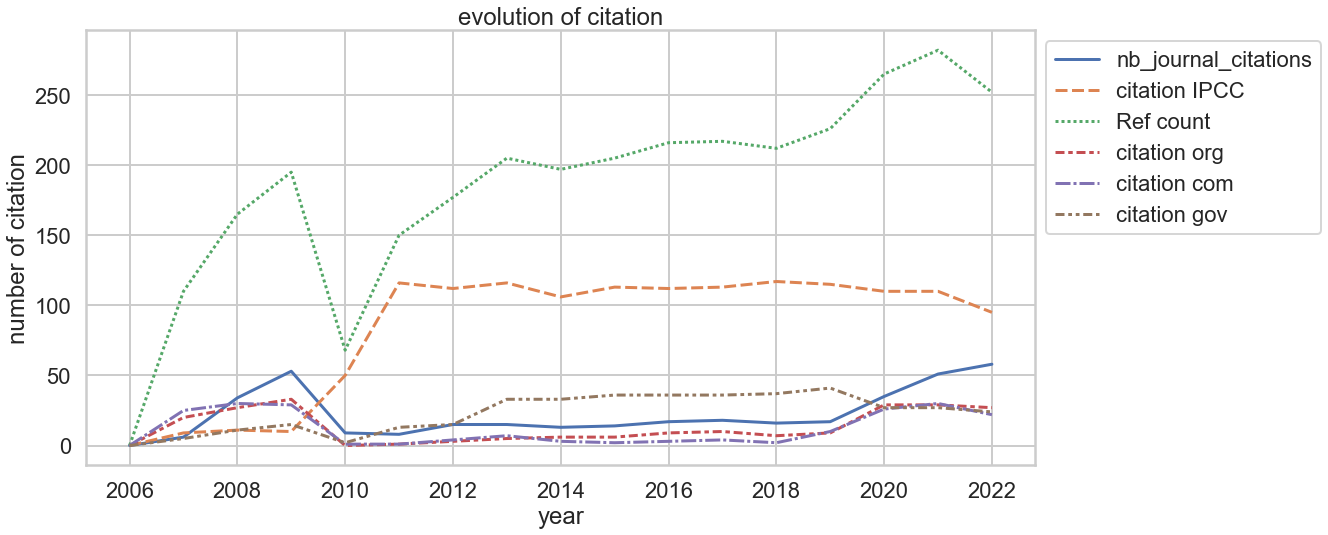

In [58]:
sns.set_style("whitegrid")
sns.lineplot(data=[df["nb_journal_citations"],df["citation IPCC"],df["Ref count"],df["citation org"],df["citation com"], df["citation gov"]]).set(title='evolution of citation',xlabel='year',ylabel='number of citation')
plt.legend(loc = 2, bbox_to_anchor = (1,1))
#sns.set(rc={"figure.figsize":(12, 8)})
sns.set_context("poster")
plt.savefig('evolution of citation.png')

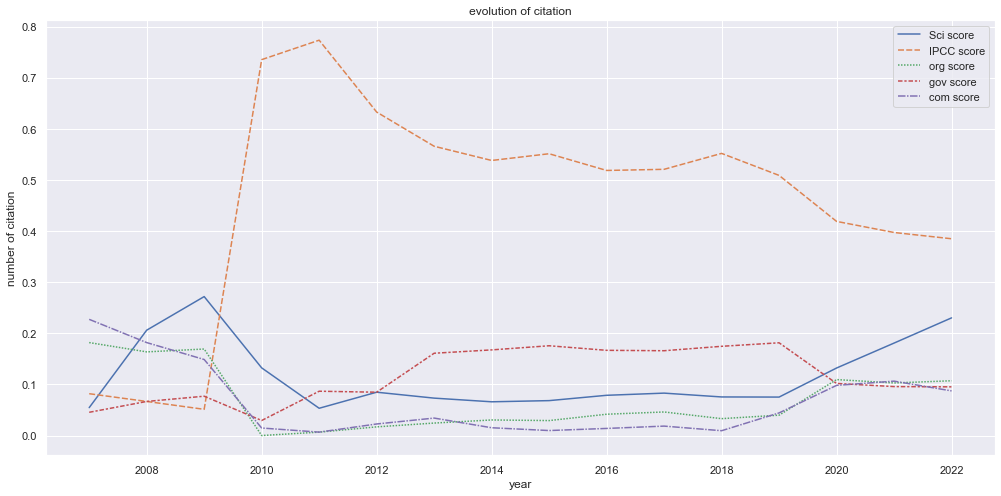

In [19]:
sns.set(rc = {'figure.figsize':(17,8)})
sns.lineplot(data=[df["Sci score"],df["IPCC score"],df["org score"],df["gov score"],df["com score"]]).set(title='evolution of citation',xlabel='year',ylabel='number of citation')

plt.savefig('rate evolution of citation.png') 

## Cleaning the column and exporting the data frame and scrap of page information

In [35]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [95]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

In [37]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

100%|████████████████████████████████████████████████████████████████████████████████| 921/921 [11:49<00:00,  1.30it/s]


In [38]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

Name only  \
Creator                                                 
Rd232                       Effects of climate change   
Jarble       Effects of climate change on agriculture   
Ppowers29   Effects of climate change on human health   
Antblasko         Effects of climate change on oceans   
Enescot       Effects of climate change on ecosystems   

                                                     page url  \
Creator                                                         
Rd232       https://en.wikipedia.org/wiki/Effects_of_clima...   
Jarble      https://en.wikipedia.org/wiki/Effects_of_clima...   
Ppowers29   https://en.wikipedia.org/wiki/Effects_of_clima...   
Antblasko   https://en.wikipedia.org/wiki/Effects_of_clima...   
Enescot     https://en.wikipedia.org/wiki/Effects_of_clima...   

                                                         text  \
Creator                                                         
Rd232       {{short description|Effects created by climate...   
Jarble      {{short description|None}}\n{{about||contribut...   
Ppowers29   [[File:Atlanta thermal.jpg|thumb|Illustration ...   
Antblasko   {{Short description|Effects of climate change ...   
Enescot     {{short description|How increased greenhouse g...   

                                                    citations  Ref count  \
Creator                                                                    
Rd232       {'Ref count': 252, 'nb_journal_citations': 58,...        252   
Jarble      {'Ref count': 142, 'nb_journal_citations': 51,...        142   
Ppowers29   {'Ref count': 111, 'nb_journal_citations': 56,...        111   
Antblasko   {'Ref count': 121, 'nb_journal_citations': 66,...        121   
Enescot     {'Ref count': 86, 'nb_journal_citations': 49, ...         86   

            nb_journal_citations  \
Creator                            
Rd232                         58   
Jarble                        51   
Ppowers29                     56   
Antblasko                     66   
Enescot                       49   

                                              journalcitation  \
Creator                                                         
Rd232       [10.1023/b:clim.0000004559.08755.88, 10.2105/a...   
Jarble      [10.1111/j.1365-3059.2010.02411.x, 10.1016/s01...   
Ppowers29   [10.2215/cjn.13841215, 10.1111/j.1365-3059.201...   
Antblasko   [10.1175/jhm600.1, 10.1073/pnas.0630310100, 10...   
Enescot     [10.1371/journal.pone.0065427, 10.1890/120282,...   

                                                      journal  citation org  \
Creator                                                                       
Rd232       [[climatic change], [american journal of publi...            27   
Jarble      [[plant pathology ], [trends in ecology ], [ca...            19   
Ppowers29   [[clin j am soc nephrol ], [plant pathology ],...            13   
Antblasko   [[journal of hydrometeorology ], [proceedings ...            14   
Enescot     [[plos one ], [frontiers in ecology and the en...             7   

                                              citationorgtext  ...   Page id  \
Creator                                                        ...             
Rd232       [openknowledge.worldbank.org, www.carbonbrief....  ...   2119174   
Jarble      [www.fao.org, www.sciencenews.org, www.unenvir...  ...  47512577   
Ppowers29   [environmentlive.unep.org, phys.org, www.grist...  ...  37063005   
Antblasko   [www.worldcat.org, www.sciencemag.org, worldca...  ...  35895879   
Enescot     [www.npr.org, www.un.org, www.nwf.org, worldca...  ...  26515241   

                                              Edit protection  \
Creator                                                         
Rd232       Require autoconfirmed or confirmed access (no ...   
Jarble                        Allow all users (no expiry set)   
Ppowers29                     Allow all users (no expiry set)   
Antblasko                     Allow all users (no 

In [39]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

#### Plot the ratio of page created by a certain editor in our corpus

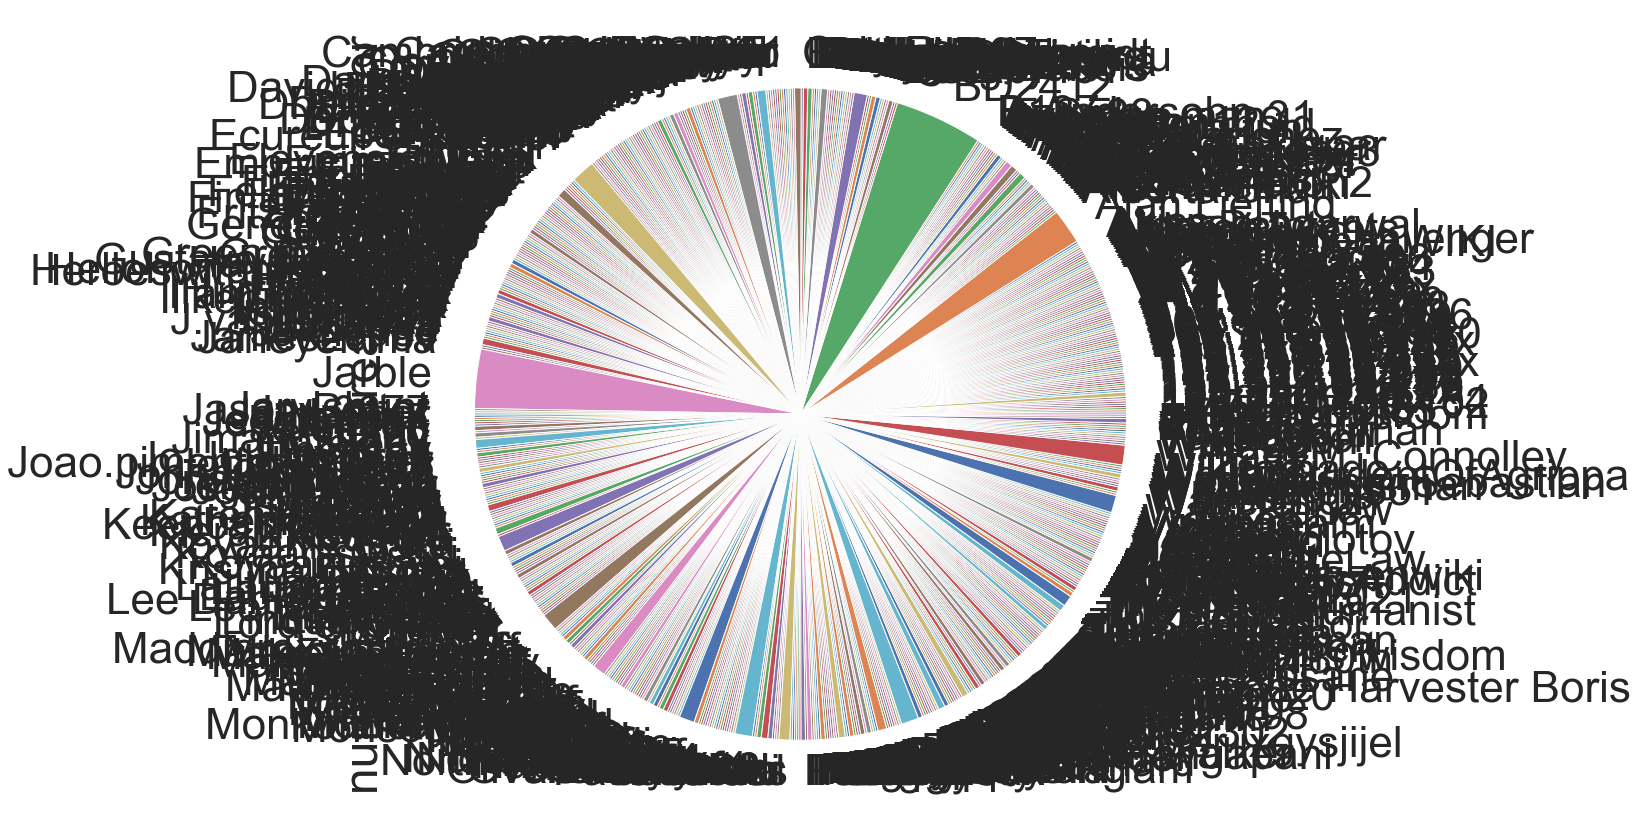

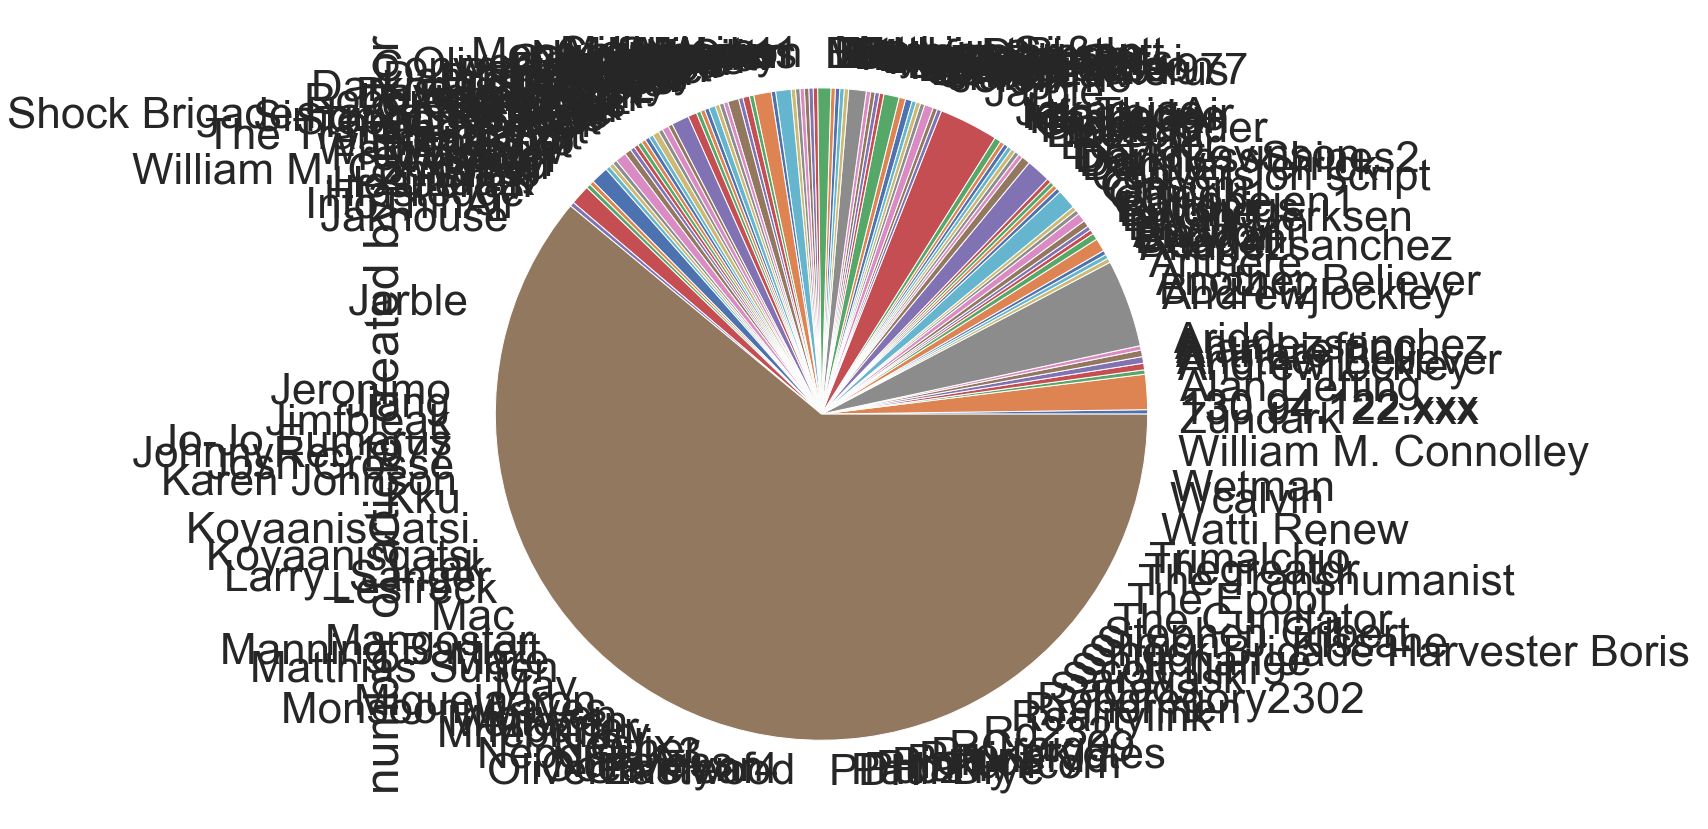

Name only  \
Creator                                                   
Rd232                         Effects of climate change   
Jarble         Effects of climate change on agriculture   
Ppowers29     Effects of climate change on human health   
Antblasko           Effects of climate change on oceans   
Enescot         Effects of climate change on ecosystems   
...                                                 ...   
Dchensummer                 Restore America's Estuaries   
Dmtk                                      Carbon bubble   
J579513                          The Hunting Hypothesis   
Fish720                         David Quinn (columnist)   
Leinad-Z                 Crisis of the Late Middle Ages   

                                                       page url  \
Creator                                                           
Rd232         https://en.wikipedia.org/wiki/Effects_of_clima...   
Jarble        https://en.wikipedia.org/wiki/Effects_of_clima...   
Ppowers29     https://en.wikipedia.org/wiki/Effects_of_clima...   
Antblasko     https://en.wikipedia.org/wiki/Effects_of_clima...   
Enescot       https://en.wikipedia.org/wiki/Effects_of_clima...   
...                                                         ...   
Dchensummer   https://en.wikipedia.org/wiki/Restore_America%...   
Dmtk                https://en.wikipedia.org/wiki/Carbon_bubble   
J579513       https://en.wikipedia.org/wiki/The_Hunting_Hypo...   
Fish720       https://en.wikipedia.org/wiki/David_Quinn_(col...   
Leinad-Z      https://en.wikipedia.org/wiki/Crisis_of_the_La...   

                                                           text  \
Creator                                                           
Rd232         {{short description|Effects created by climate...   
Jarble        {{short description|None}}\n{{about||contribut...   
Ppowers29     [[File:Atlanta thermal.jpg|thumb|Illustration ...   
Antblasko     {{Short description|Effects of climate change ...   
Enescot       {{short description|How increased greenhouse g...   
...                                                         ...   
Dchensummer   ["RAE also has focused on the impacts of clima...   
Dmtk          ['A detailed academic study of the consequence...   
J579513       ['\'\'The Hunting Hypothesis\'\' was also one ...   
Fish720       ['\nQuinn is highly outspoken in his denial of...   
Leinad-Z      ['The Black Death was a particularly devastati...   

                                                      citations  Ref count  \
Creator                                                                      
Rd232         {'Ref count': 252, 'nb_journal_citations': 58,...        252   
Jarble        {'Ref count': 142, 'nb_journal_citations': 51,...        142   
Ppowers29     {'Ref count': 111, 'nb_journal_citations': 56,...        111   
Antblasko     {'Ref count': 121, 'nb_journal_citations': 66,...        121   
Enescot       {'Ref count': 86, 'nb_journal_citations': 49, ...         86   
...                                                         ...        ...   
Dchensummer   {'Ref count': 1, 'nb_journal_citations': 0, 'c...          1   
Dmtk          {'Ref count': 5, 'nb_journal_citations': 2, 'c...          5   
J579513       {'Ref count': 1, 'nb_journal_citations': 0, 'c...          1   
Fish720       {'Ref count': 13, 'nb_journal_citations': 0, '...         13   
Leinad-Z      {'Ref count': 3, 'nb_journal_citations': 3, 'c...          3   

              nb_journal_citations  \
Creator                              
Rd232                           58   
Jarble                          51   
Ppowers29                       56   
Antblasko                       66   
Enescot                         49   
...                            ...   
Dchensummer                      0   
Dmtk                             2   
J579513                          0   
Fish720                          0   
Leinad-Z                         3   

                        

In [40]:
#creation of a new dataframe
dfbis=df

dfbis["number of article created by creator"]=1
dfbis.set_index("Creator",inplace=True)
dfbis=dfbis.groupby("Creator")["number of article created by creator"].sum()

fig = plt.figure(0,figsize=(20,15))
dfbis.plot.pie(subplots=True)
fig.savefig('article_created_by_creator.jpg', bbox_inches='tight', dpi=150)

fig2 = plt.figure(1,figsize=(20,15))
dfwithoutother=dfbis[dfbis>1]
dfwithoutother.plot.pie(subplots=True)

dftris=dfbis[dfbis==1].sum()
dfbis.loc["Other"]=dftris


fig3 = plt.figure(1,figsize=(20,15))
dfbis[dfbis>1].plot.pie(subplots=True)
fig2.savefig('article_created_by_important_creator.jpg', bbox_inches='tight', dpi=150)

plt.show()
df

#### plot of the timeline

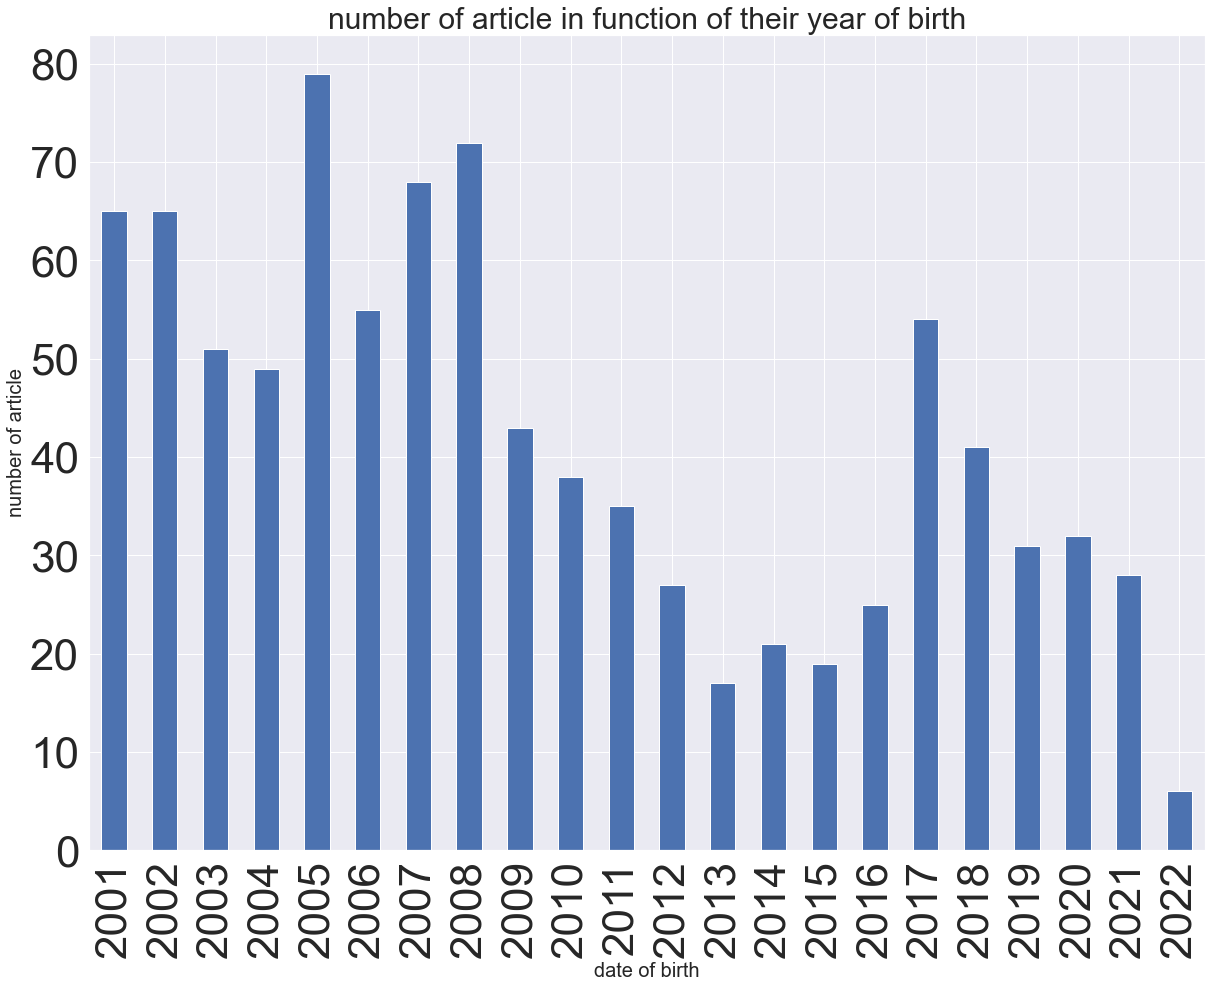

In [37]:
fig = plt.figure(0,figsize=(20,15))
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")
fig.savefig('timeline.jpg', bbox_inches='tight', dpi=150)
plt.xlabel('date of birth',fontsize = 20) 
plt.ylabel('number of article',fontsize = 20) 
plt.title("number of article in function of their year of birth",fontsize = 30)
plt.show()

#### Clean and export the dataframes to csv

In [258]:
del df['citationorgtext']
del df['citationgovtext']
del df['text']
del df["citations"]
del df["citationcomtext"]

In [49]:
#extract the data frame to csv
df.to_csv('climatechange.csv')
dforg.to_csv('climatechangeorg.csv')
dfgov.to_csv('climatechangegov.csv')
dcom.to_csv('climatechangecom.csv')

"\ndfgov.to_csv('climatechangegov.csv')\ndcom.to_csv('climatechangecom.csv')"